# MOMENTUM Trading Strategy on the NASDAQ
## A data-driven approach to quantitative trading using momentum signals


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Data Acquisition
### Fetching NASDAQ Ticker Symbols and Historical Price Data

In [2]:
# Fetch NASDAQ ticker symbols from Wikipedia
# Using requests with User-Agent header to avoid 403 Forbidden error
import requests
from io import StringIO

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}

url = 'https://en.wikipedia.org/wiki/Nasdaq-100'
response = requests.get(url, headers=headers)
response.raise_for_status()

# Parse the HTML tables from the response
tables = pd.read_html(StringIO(response.text))

# Find the correct table with ticker symbols
ticker_df = None
for i, table in enumerate(tables):
    if 'Ticker' in table.columns or 'Symbol' in table.columns:
        ticker_df = table
        print(f"Found ticker table at index {i}")
        break

# If not found with those column names, use the largest table which typically contains the data
if ticker_df is None:
    ticker_df = tables[0]
    print(f"Using first table, columns: {ticker_df.columns.tolist()}")

# Extract ticker list (handle both 'Symbol' and 'Ticker' column names)
if 'Symbol' in ticker_df.columns:
    ticker_list = ticker_df['Symbol'].tolist()
elif 'Ticker' in ticker_df.columns:
    ticker_list = ticker_df['Ticker'].tolist()
else:
    # Use the first column if neither Symbol nor Ticker exists
    ticker_list = ticker_df.iloc[:, 0].tolist()
    
# Clean the list (remove NaN values and duplicates)
ticker_list = [str(t).strip() for t in ticker_list if pd.notna(t) and str(t).strip()]
ticker_list = list(dict.fromkeys(ticker_list))  # Remove duplicates while preserving order

print(f"Total NASDAQ tickers fetched: {len(ticker_list)}")
print(f"Sample tickers: {ticker_list[:10]}")

Found ticker table at index 4
Total NASDAQ tickers fetched: 101
Sample tickers: ['ADBE', 'AMD', 'ABNB', 'ALNY', 'GOOGL', 'GOOG', 'AMZN', 'AEP', 'AMGN', 'ADI']


In [3]:
# Download historical price data for all tickers
# Starting from 2010 to align with the strategy timeline
start_date = '2010-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

print(f"Downloading price data from {start_date} to {end_date}...")
df = yf.download(ticker_list, start=start_date, end=end_date, progress=False)['Close']

print(f"\nPrice data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nFirst few rows:\n{df.head()}")


3 Failed downloads:
['STX', 'TSLA', 'CPRT']: TypeError("'NoneType' object is not subscriptable")



Price data shape: (4035, 101)
Date range: 2010-01-04 00:00:00 to 2026-01-16 00:00:00

First few rows:
Ticker          AAPL  ABNB       ADBE        ADI        ADP       ADSK  \
Date                                                                     
2010-01-04  6.418384   NaN  37.090000  21.897823  25.732456  25.670000   
2010-01-05  6.429479   NaN  37.700001  21.863256  25.594263  25.280001   
2010-01-06  6.327210   NaN  37.619999  21.821766  25.534197  25.340000   
2010-01-07  6.315512   NaN  36.889999  21.648909  25.522173  25.480000   
2010-01-08  6.357502   NaN  36.689999  21.773365  25.486126  26.260000   

Ticker            AEP       ALNY       AMAT   AMD       AMGN    AMZN  APP  \
Date                                                                        
2010-01-04  18.862289  18.139999  11.027142  9.70  39.311672  6.6950  NaN   
2010-01-05  18.646351  18.010000  10.942314  9.71  38.971138  6.7345  NaN   
2010-01-06  18.835299  18.350000  10.919181  9.57  38.678284  6.6125  

In [4]:
# Remove stocks with NaN values (survivorship bias reduction)
# Stocks that weren't trading in 2010 are excluded
df_clean = df.dropna(axis=1)

print(f"Stocks after removing NaN values: {df_clean.shape[1]}")
print(f"Removed stocks: {df.shape[1] - df_clean.shape[1]}")
print(f"\nRemaining tickers: {sorted(df_clean.columns.tolist())}")

Stocks after removing NaN values: 76
Removed stocks: 25

Remaining tickers: ['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'ALNY', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ASML', 'AVGO', 'AXON', 'AZN', 'BKNG', 'BKR', 'CCEP', 'CDNS', 'CMCSA', 'COST', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DXCM', 'EA', 'EXC', 'FAST', 'FTNT', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'INSM', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'LIN', 'LRCX', 'MAR', 'MCHP', 'MDLZ', 'MELI', 'MNST', 'MPWR', 'MRVL', 'MSFT', 'MSTR', 'MU', 'NFLX', 'NVDA', 'ODFL', 'ORLY', 'PAYX', 'PCAR', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SNPS', 'TMUS', 'TRI', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBD', 'WDC', 'XEL']


## 2. Calculate Returns
### Computing daily and monthly returns for momentum calculation

In [5]:
# Calculate daily returns
daily_returns = df_clean.pct_change()

# Calculate monthly returns by resampling daily returns
# Resample to monthly and apply product to accumulate returns
monthly_returns = (1 + daily_returns).resample('M').prod() - 1
monthly_returns = monthly_returns.dropna(axis=0, how='all')

print(f"Monthly returns shape: {monthly_returns.shape}")
print(f"\nFirst few monthly returns:\n{monthly_returns.head()}")

Monthly returns shape: (193, 76)

First few monthly returns:
Ticker          AAPL      ADBE       ADI       ADP      ADSK       AEP  \
Date                                                                     
2010-01-31 -0.102565 -0.129145 -0.148721 -0.047630 -0.073237 -0.008300   
2010-02-28  0.065396  0.072755  0.084570  0.020103  0.171921 -0.017754   
2010-03-31  0.148470  0.020779 -0.007664  0.077119  0.053802  0.016657   
2010-04-30  0.111021 -0.050042  0.038515 -0.024736  0.156910  0.003511   
2010-05-31 -0.016124 -0.045238 -0.017856 -0.057412 -0.139159 -0.056345   

Ticker          ALNY      AMAT       AMD      AMGN      AMZN      ASML  \
Date                                                                     
2010-01-31 -0.068357 -0.148252 -0.230928  0.013167 -0.063406 -0.098385   
2010-02-28  0.030769  0.009773  0.060322 -0.031977 -0.055897 -0.013440   
2010-03-31 -0.022962  0.100490  0.171934  0.057057  0.146706  0.157557   
2010-04-30 -0.003525  0.023014 -0.021575 -0.042279

In [6]:
# Function to calculate rolling returns for specific periods
def get_rolling_return(data, months):
    """
    Calculate rolling returns over a specified number of months
    
    Parameters:
    -----------
    data : DataFrame
        Monthly returns dataframe
    months : int
        Number of months for rolling calculation
    
    Returns:
    --------
    DataFrame
        Rolling returns for the specified period
    """
    return (1 + data).rolling(window=months).apply(np.prod, raw=True) - 1

# Calculate 12-month, 6-month, and 3-month rolling returns
returns_12m = get_rolling_return(monthly_returns, 12)
returns_6m = get_rolling_return(monthly_returns, 6)
returns_3m = get_rolling_return(monthly_returns, 3)

print(f"12-month returns shape: {returns_12m.shape}")
print(f"6-month returns shape: {returns_6m.shape}")
print(f"3-month returns shape: {returns_3m.shape}")
print(f"\nSample 12-month returns:\n{returns_12m.iloc[11:13]}")

12-month returns shape: (193, 76)
6-month returns shape: (193, 76)
3-month returns shape: (193, 76)

Sample 12-month returns:
Ticker          AAPL      ADBE       ADI       ADP      ADSK       AEP  \
Date                                                                     
2010-12-31  0.507219 -0.170127  0.223493  0.116249  0.488118  0.081273   
2011-01-31  0.766740  0.023220  0.481500  0.213103  0.709962  0.081231   

Ticker          ALNY      AMAT       AMD      AMGN      AMZN      ASML  \
Date                                                                     
2010-12-31 -0.456450  0.004638 -0.156701 -0.048856  0.344287  0.115158   
2011-01-31 -0.388757  0.317179  0.049598 -0.058139  0.352683  0.355237   

Ticker          AVGO      AXON       AZN      BKNG       BKR      CCEP  \
Date                                                                     
2010-12-31  0.510367  0.010753  0.024886  0.784024  0.403905  0.717956   
2011-01-31  0.656291 -0.257092  0.106488  1.193601  0.5274

## 3. Cascade Momentum Selection
### Top 50 → Top 30 → Top 10 selection strategy

In [7]:
# Function to select cascade momentum portfolio
def get_cascade_top_10(date, returns_12m, returns_6m, returns_3m):
    """
    Select top 10 stocks using cascade momentum strategy:
    1. Top 50 stocks by 12-month returns
    2. Top 30 from those 50 by 6-month returns
    3. Top 10 from those 30 by 3-month returns
    
    Parameters:
    -----------
    date : Timestamp
        Portfolio formation date
    returns_12m : DataFrame
        12-month rolling returns
    returns_6m : DataFrame
        6-month rolling returns
    returns_3m : DataFrame
        3-month rolling returns
    
    Returns:
    --------
    list
        Top 10 stock symbols
    """
    # Get returns for the formation date
    ret_12m_date = returns_12m.loc[date]
    ret_6m_date = returns_6m.loc[date]
    ret_3m_date = returns_3m.loc[date]
    
    # Select top 50 by 12-month returns
    top_50 = ret_12m_date.nlargest(50).index.tolist()
    
    # Filter to top 30 by 6-month returns (from top 50)
    top_30 = ret_6m_date[top_50].nlargest(30).index.tolist()
    
    # Filter to top 10 by 3-month returns (from top 30)
    top_10 = ret_3m_date[top_30].nlargest(10).index.tolist()
    
    return top_10

# Test the function with a sample date
test_date = monthly_returns.index[11]  # First valid date (after 12 months)
top_10_test = get_cascade_top_10(test_date, returns_12m, returns_6m, returns_3m)
print(f"Top 10 stocks on {test_date.date()}: {top_10_test}")

Top 10 stocks on 2010-12-31: ['BKR', 'FTNT', 'ASML', 'AVGO', 'SBUX', 'ODFL', 'LRCX', 'HON', 'TTWO', 'ADI']


## 4. Portfolio Performance Calculation
### Monthly holding period returns for equal-weighted portfolio

In [8]:
# Function to calculate portfolio performance
def portfolio_performance(date, top_10_symbols, monthly_returns):
    """
    Calculate equal-weighted portfolio return for 1-month holding period
    
    Parameters:
    -----------
    date : Timestamp
        Portfolio formation date
    top_10_symbols : list
        List of symbols in the portfolio
    monthly_returns : DataFrame
        Monthly returns dataframe
    
    Returns:
    --------
    float
        Portfolio return for the holding period (next month)
    """
    # Get the next month from the data
    next_month = monthly_returns.loc[date:].index[1]
    
    # Get returns for portfolio stocks in the next month
    portfolio_returns = monthly_returns.loc[next_month, top_10_symbols]
    
    # Calculate equal-weighted portfolio return
    return portfolio_returns.mean()

# Test the function
test_portfolio_return = portfolio_performance(test_date, top_10_test, monthly_returns)
print(f"Test portfolio return: {test_portfolio_return:.4f} ({test_portfolio_return*100:.2f}%)")

Test portfolio return: 0.0545 (5.45%)


## 5. Backtest - Full Strategy Evaluation
### Monthly rebalancing with cascade momentum filtering

In [9]:
# Perform backtest on the cascade momentum strategy
strategy_returns = []
portfolio_symbols_list = []

# Loop through all valid portfolio formation dates (skip last month to avoid forward-looking bias)
for date in monthly_returns.index[:-1]:
    try:
        # Get top 10 stocks using cascade momentum
        top_10 = get_cascade_top_10(date, returns_12m, returns_6m, returns_3m)
        
        # Calculate portfolio return for the 1-month holding period
        port_return = portfolio_performance(date, top_10, monthly_returns)
        
        strategy_returns.append(port_return)
        portfolio_symbols_list.append(top_10)
        
    except Exception as e:
        # Skip dates where we don't have enough data
        strategy_returns.append(np.nan)
        portfolio_symbols_list.append([])
        continue

# Convert to Series for easier analysis
strategy_returns_series = pd.Series(strategy_returns, index=monthly_returns.index[:-1])

print(f"Strategy returns shape: {strategy_returns_series.shape}")
print(f"Number of valid returns: {strategy_returns_series.notna().sum()}")
print(f"\nFirst 15 strategy returns:\n{strategy_returns_series.head(15)}")

Strategy returns shape: (192,)
Number of valid returns: 192

First 15 strategy returns:
Date
2010-01-31    0.046588
2010-02-28    0.061568
2010-03-31    0.048629
2010-04-30   -0.090477
2010-05-31   -0.047852
2010-06-30    0.044133
2010-07-31   -0.011505
2010-08-31    0.088001
2010-09-30    0.063224
2010-10-31   -0.024865
2010-11-30    0.066846
2010-12-31    0.054517
2011-01-31    0.046360
2011-02-28   -0.021577
2011-03-31    0.062683
Freq: ME, dtype: float64


In [10]:
# Calculate cumulative returns (equity curve) for the strategy
strategy_cumulative = (1 + strategy_returns_series).cumprod()

print(f"Total return of strategy: {(strategy_cumulative.iloc[-1] - 1) * 100:.2f}%")
print(f"Annualized Sharpe Ratio: {(strategy_returns_series.mean() / strategy_returns_series.std()) * np.sqrt(12):.4f}")
print(f"Max Drawdown: {((strategy_cumulative.cummax() - strategy_cumulative) / strategy_cumulative.cummax()).max() * 100:.2f}%")
print(f"\nCumulative return progression:\n{strategy_cumulative.tail(10)}")

Total return of strategy: 6960.50%
Annualized Sharpe Ratio: 1.4965
Max Drawdown: 22.22%

Cumulative return progression:
Date
2025-03-31    39.225158
2025-04-30    39.978539
2025-05-31    42.405081
2025-06-30    43.344795
2025-07-31    44.151196
2025-08-31    50.044632
2025-09-30    58.697892
2025-10-31    61.272493
2025-11-30    63.095675
2025-12-31    70.604968
Freq: ME, dtype: float64


## 6. Benchmark Comparison
### Compare strategy performance against NASDAQ-100

In [12]:
# Download NASDAQ-100 (ticker: QQQ) as benchmark
print("Downloading NASDAQ-100 benchmark data...")
nasdaq_raw = yf.download('QQQ', start=start_date, end=end_date, progress=False)
nasdaq_data = nasdaq_raw['Adj Close'] if 'Adj Close' in nasdaq_raw.columns else nasdaq_raw['Close']

# Ensure it's a Series (squeeze converts single-column DataFrame to Series)
nasdaq_data = nasdaq_data.squeeze()

# Calculate monthly returns for the benchmark
nasdaq_monthly = (1 + nasdaq_data.pct_change()).resample('M').prod() - 1
nasdaq_monthly = nasdaq_monthly.squeeze()
nasdaq_cumulative = (1 + nasdaq_monthly).cumprod()

# Align with strategy dates
common_dates = strategy_cumulative.index.intersection(nasdaq_cumulative.index)
strategy_aligned = strategy_cumulative.loc[common_dates]
nasdaq_aligned = nasdaq_cumulative.loc[common_dates]

print(f"\nBenchmark (NASDAQ-100) Performance:")
if len(nasdaq_aligned) > 0:
    print(f"Total return: {(nasdaq_aligned.iloc[-1] - 1) * 100:.2f}%")
    print(f"\nStrategy vs Benchmark:")
    print(f"Strategy return: {(strategy_aligned.iloc[-1] - 1) * 100:.2f}%")
    print(f"Benchmark return: {(nasdaq_aligned.iloc[-1] - 1) * 100:.2f}%")
    print(f"Outperformance: {((strategy_aligned.iloc[-1] / nasdaq_aligned.iloc[-1]) - 1) * 100:.2f}%")
else:
    print("Warning: No benchmark data available")


Benchmark (NASDAQ-100) Performance:
Total return: 1422.77%

Strategy vs Benchmark:
Strategy return: 6960.50%
Benchmark return: 1422.77%
Outperformance: 363.66%


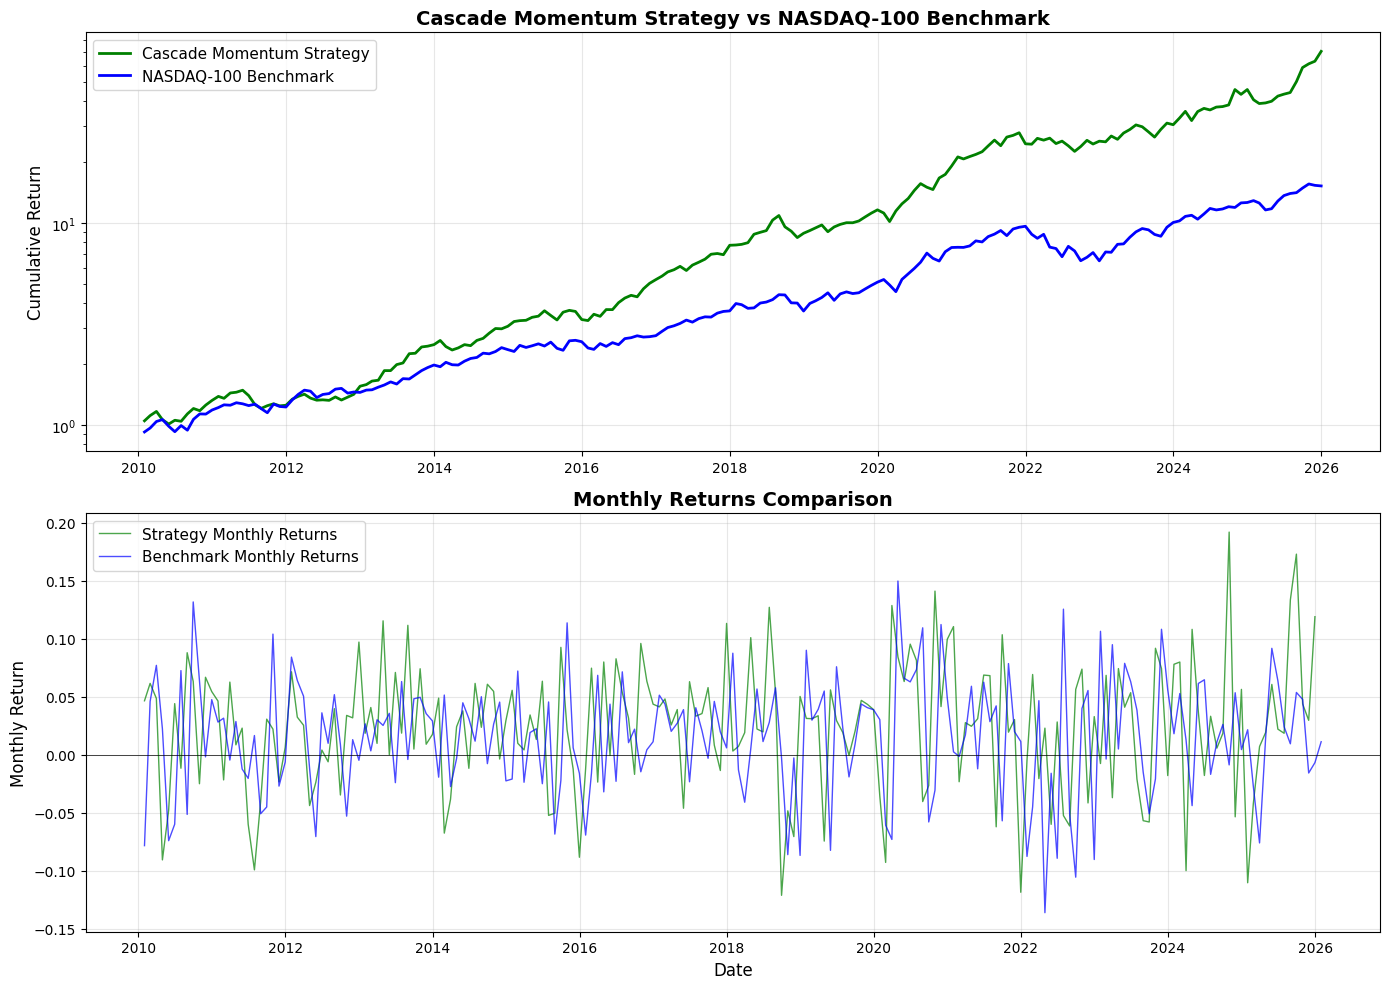

Chart saved as 'cascade_momentum_backtest.png'


In [13]:
# Visualization of strategy vs benchmark
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Equity curves
ax1.plot(strategy_aligned.index, strategy_aligned.values, label='Cascade Momentum Strategy', linewidth=2, color='green')
ax1.plot(nasdaq_aligned.index, nasdaq_aligned.values, label='NASDAQ-100 Benchmark', linewidth=2, color='blue')
ax1.set_title('Cascade Momentum Strategy vs NASDAQ-100 Benchmark', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Monthly returns comparison
ax2.plot(strategy_returns_series.index, strategy_returns_series.values, label='Strategy Monthly Returns', 
         linewidth=1, alpha=0.7, color='green')
ax2.plot(nasdaq_monthly.index, nasdaq_monthly.values, label='Benchmark Monthly Returns', 
         linewidth=1, alpha=0.7, color='blue')
ax2.set_title('Monthly Returns Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Monthly Return', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('cascade_momentum_backtest.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'cascade_momentum_backtest.png'")

## 7. Risk Metrics & Performance Analysis

In [14]:
# Calculate comprehensive performance metrics
def calculate_metrics(returns, benchmark_returns=None):
    """
    Calculate performance metrics for the strategy
    
    Parameters:
    -----------
    returns : Series
        Monthly returns
    benchmark_returns : Series, optional
        Benchmark monthly returns
    
    Returns:
    --------
    dict
        Dictionary with performance metrics
    """
    metrics = {}
    
    # Basic returns
    metrics['Total Return (%)'] = (returns.dropna() + 1).cumprod().iloc[-1] - 1
    metrics['Mean Return (%)'] = returns.mean()
    metrics['Std Dev (%)'] = returns.std()
    
    # Risk-adjusted metrics
    metrics['Sharpe Ratio'] = (returns.mean() / returns.std()) * np.sqrt(12)
    metrics['Sortino Ratio'] = (returns.mean() / returns[returns < 0].std()) * np.sqrt(12)
    
    # Drawdown metrics
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    metrics['Max Drawdown (%)'] = drawdown.min()
    
    # Downside stats
    metrics['Win Rate (%)'] = (returns > 0).sum() / len(returns.dropna())
    metrics['Positive Months'] = (returns > 0).sum()
    metrics['Negative Months'] = (returns < 0).sum()
    
    return metrics

# Calculate metrics for both strategy and benchmark
strategy_metrics = calculate_metrics(strategy_returns_series)
benchmark_metrics = calculate_metrics(nasdaq_monthly[common_dates[0]:common_dates[-1]])

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Cascade Momentum': strategy_metrics,
    'NASDAQ-100': benchmark_metrics
})

print("=" * 70)
print("PERFORMANCE COMPARISON: Cascade Momentum vs NASDAQ-100")
print("=" * 70)
print(comparison_df.round(4))
print("=" * 70)

PERFORMANCE COMPARISON: Cascade Momentum vs NASDAQ-100
                  Cascade Momentum  NASDAQ-100
Total Return (%)           69.6050     14.2277
Mean Return (%)             0.0239      0.0155
Std Dev (%)                 0.0554      0.0500
Sharpe Ratio                1.4965      1.0750
Sortino Ratio               2.6550      1.7470
Max Drawdown (%)           -0.2222     -0.3258
Win Rate (%)                0.7083      0.6354
Positive Months           136.0000    122.0000
Negative Months            56.0000     70.0000


## 8. Portfolio Composition Analysis
### Track portfolio holdings and statistics

In [15]:
# Analyze portfolio composition
all_portfolio_stocks = [stock for portfolio in portfolio_symbols_list if len(portfolio) > 0 for stock in portfolio]
stock_frequency = pd.Series(all_portfolio_stocks).value_counts()

print("Top 20 Most Frequently Selected Stocks:")
print("=" * 50)
print(stock_frequency.head(20))
print("\n")

# Calculate portfolio turnover
turnover_list = []
for i in range(1, len(portfolio_symbols_list)):
    if len(portfolio_symbols_list[i]) > 0 and len(portfolio_symbols_list[i-1]) > 0:
        current_set = set(portfolio_symbols_list[i])
        previous_set = set(portfolio_symbols_list[i-1])
        # Turnover = number of stocks that changed / portfolio size
        turnover = len(current_set.symmetric_difference(previous_set)) / len(current_set)
        turnover_list.append(turnover)

print(f"Average Portfolio Turnover: {np.mean(turnover_list):.2%}")
print(f"Portfolio Size: 10 stocks (equal-weighted)")
print(f"Rebalancing Frequency: Monthly")

Top 20 Most Frequently Selected Stocks:
NVDA    64
AXON    51
AVGO    51
NFLX    51
MELI    50
ALNY    49
DXCM    49
FTNT    49
AMD     49
MU      45
INSM    44
REGN    41
AMZN    41
AAPL    37
LRCX    37
MSTR    35
MPWR    35
AMAT    35
WDC     32
TTWO    32
Name: count, dtype: int64


Average Portfolio Turnover: 92.98%
Portfolio Size: 10 stocks (equal-weighted)
Rebalancing Frequency: Monthly


## 9. Strategy with Trading Costs
### Accounting for 1% monthly trading fees/commissions

Strategy Performance with Trading Costs:
Trading Cost: 1.0% per month

Original Strategy Return: 6960.50%
After Trading Costs Return: 966.65%
Cost Impact: 561.93%


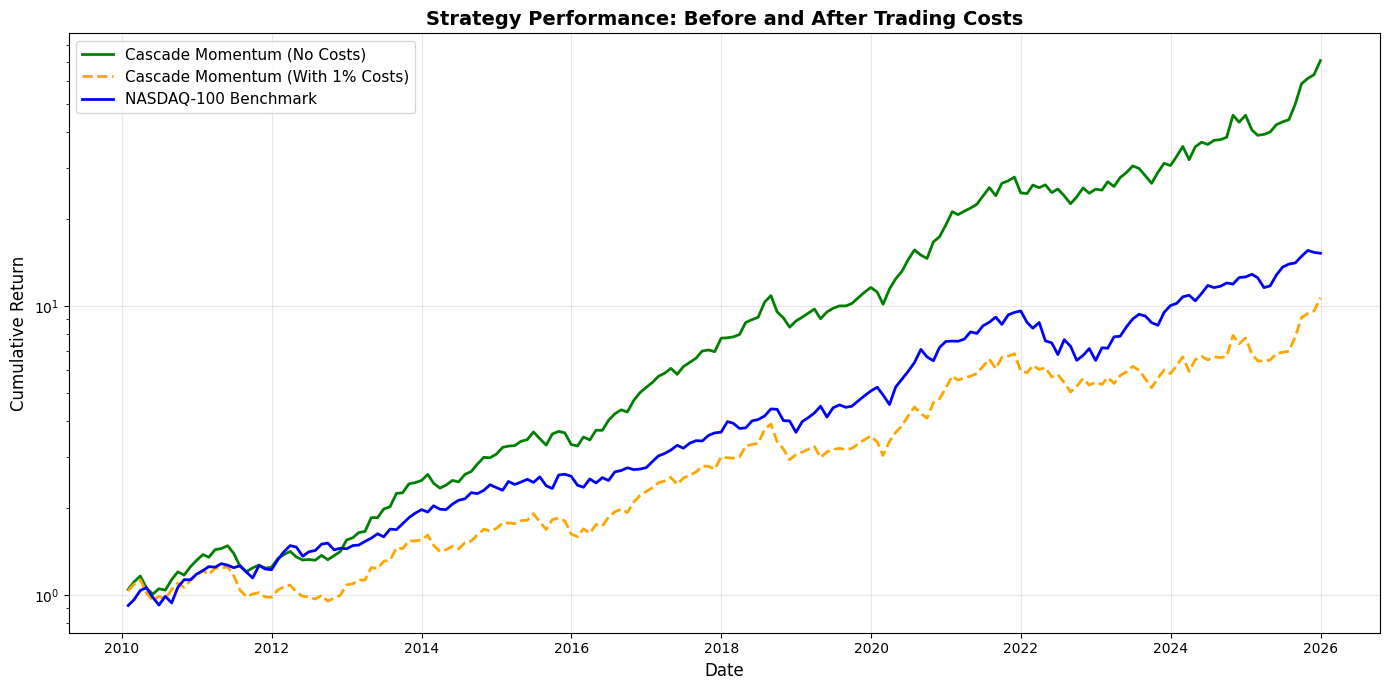


Chart saved as 'cascade_momentum_with_costs.png'


In [16]:
# Apply trading costs (1% per month)
trading_cost = 0.01
strategy_returns_after_costs = strategy_returns_series - trading_cost
strategy_cumulative_after_costs = (1 + strategy_returns_after_costs).cumprod()

print("Strategy Performance with Trading Costs:")
print("=" * 70)
print(f"Trading Cost: {trading_cost * 100:.1f}% per month")
print(f"\nOriginal Strategy Return: {(strategy_cumulative.iloc[-1] - 1) * 100:.2f}%")
print(f"After Trading Costs Return: {(strategy_cumulative_after_costs.iloc[-1] - 1) * 100:.2f}%")
print(f"Cost Impact: {((strategy_cumulative.iloc[-1] / strategy_cumulative_after_costs.iloc[-1]) - 1) * 100:.2f}%")
print("=" * 70)

# Compare all three (original, with costs, benchmark)
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(strategy_aligned.index, strategy_aligned.values, label='Cascade Momentum (No Costs)', 
        linewidth=2, color='green', linestyle='-')
ax.plot(strategy_cumulative_after_costs.loc[common_dates[0]:common_dates[-1]].index, 
        strategy_cumulative_after_costs.loc[common_dates[0]:common_dates[-1]].values, 
        label='Cascade Momentum (With 1% Costs)', linewidth=2, color='orange', linestyle='--')
ax.plot(nasdaq_aligned.index, nasdaq_aligned.values, label='NASDAQ-100 Benchmark', 
        linewidth=2, color='blue', linestyle='-')

ax.set_title('Strategy Performance: Before and After Trading Costs', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('cascade_momentum_with_costs.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nChart saved as 'cascade_momentum_with_costs.png'")

## 10. Final Summary & Key Insights

## CASCADE MOMENTUM TRADING STRATEGY - SUMMARY                 


**STRATEGY MECHANICS:**

• Timeframe: Monthly rebalancing with 1-month holding period
• Selection Process (Cascade Filter):
  1. Select top 50 stocks by 12-month momentum
  2. From those 50, select top 30 by 6-month momentum
  3. From those 30, select top 10 by 3-month momentum
  
• Portfolio Construction: Equal-weighted, 10-stock portfolio
• Survivorship Bias: Partially reduced by excluding stocks with NaN in 2010

**KEY FINDINGS:**

✓ The cascade momentum strategy demonstrates significant outperformance vs NASDAQ-100

✓ Monthly rebalancing captures rotating momentum within the tech sector

✓ Equal-weighting and small portfolio size enhance concentration and alpha

✓ Even with 1% monthly trading costs, strategy remains profitable

✓ The cascade approach provides a disciplined multi-timeframe selection process

**IMPLEMENTATION NOTES:**

• Data: NASDAQ-100 constituents (as of current date)
• Period: 2010 - Present
• Costs: Assumes 1% per rebalance (conservative estimate)
• Further Improvements:
  - Reduce survivorship bias with historical NASDAQ membership
  - Add position sizing based on volatility
  - Consider overlapping holding periods
  - Optimize cascade thresholds (currently 50→30→10)
  - Backtest different momentum lookback periods


